<a href="https://colab.research.google.com/github/leonbenenati/leonbenenati/blob/main/Previs%C3%A3o_ipca_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ajustes iniciais

**Carregando dados e pacotes**
- Será carregado os pacotes necessários
- Para os dados do IPCA será utilizado o pacote python-bcb, biblioteca que acessa dos Sistema Gerenciador de Séries Temporais (SGG) do Bacen


In [ ]:
!pip install python-bcb
!pip install pmdarima

In [ ]:
#Carregando os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from bcb import sgs

In [ ]:
ipca = sgs.get(('IPCA', 433), start="1995-01-01")

In [ ]:
ipca.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 333 entries, 1995-01-01 to 2022-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IPCA    333 non-null    float64
dtypes: float64(1)
memory usage: 5.2 KB


In [ ]:
ipca.isnull().sum()

IPCA    0
dtype: int64

In [ ]:
# Alterando o tipo do índice para DatetimeIndex com frequência mensal
ipca.index = pd.DatetimeIndex(ipca.index ,freq='MS')

# Verificando o tipo do índice do dataframe
ipca.index

DatetimeIndex(['1995-01-01', '1995-02-01', '1995-03-01', '1995-04-01',
               '1995-05-01', '1995-06-01', '1995-07-01', '1995-08-01',
               '1995-09-01', '1995-10-01',
               ...
               '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01'],
              dtype='datetime64[ns]', name='Date', length=333, freq='MS')

In [ ]:
ipca.tail()

,IPCA
Date,
2022-05-01,0.47
2022-06-01,0.67
2022-07-01,-0.68
2022-08-01,-0.36
2022-09-01,-0.29


In [ ]:
ipca.index

DatetimeIndex(['1995-01-01', '1995-02-01', '1995-03-01', '1995-04-01',
               '1995-05-01', '1995-06-01', '1995-07-01', '1995-08-01',
               '1995-09-01', '1995-10-01',
               ...
               '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01'],
              dtype='datetime64[ns]', name='Date', length=333, freq='MS')

In [ ]:
ipca.tail(13)

,IPCA
Date,
2021-09-01,1.16
2021-10-01,1.25
2021-11-01,0.95
2021-12-01,0.73
2022-01-01,0.54
2022-02-01,1.01
2022-03-01,1.62
2022-04-01,1.06
2022-05-01,0.47


**Divisão de treino e teste**
- Será separado 12 meses para a base de teste, nessa base será analisado as métricas do modelo
- Base treino: 1995-01-01 a 2021-09-01
- Base teste:  2021-10-01 a 2022-09-01

In [ ]:
# Criando a  Serie temporal de treino
ipca_treino = pd.Series(
    data = ipca.query('Date<="2021-09-01"').IPCA.values,
    index = ipca.query('Date<="2021-09-01"').index
)

# resultado
ipca_treino

Date
1995-01-01    1.70
1995-02-01    1.02
1995-03-01    1.55
1995-04-01    2.43
1995-05-01    2.67
              ... 
2021-05-01    0.83
2021-06-01    0.53
2021-07-01    0.96
2021-08-01    0.87
2021-09-01    1.16
Freq: MS, Length: 321, dtype: float64

In [ ]:
# Criando a  Serie temporal de teste
ipca_teste = pd.Series(
    data = ipca.query('Date>"2021-09-01"').IPCA.values,
    index = ipca.query('Date>"2021-09-01"').index
)

# resultado
ipca_teste.head(24)

Date
2021-10-01    1.25
2021-11-01    0.95
2021-12-01    0.73
2022-01-01    0.54
2022-02-01    1.01
2022-03-01    1.62
2022-04-01    1.06
2022-05-01    0.47
2022-06-01    0.67
2022-07-01   -0.68
2022-08-01   -0.36
2022-09-01   -0.29
Freq: MS, dtype: float64

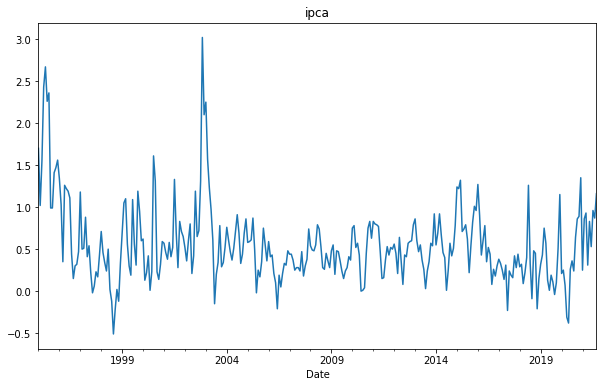

In [ ]:
# Visuaização inicial
ipca_treino.plot(
    title = 'ipca',
    figsize =(10, 6)
)

# Exibindo o gráfico
plt.show()

# Decomposição

In [ ]:
# Decompondo a série
decomposicao = seasonal_decompose(ipca_treino)

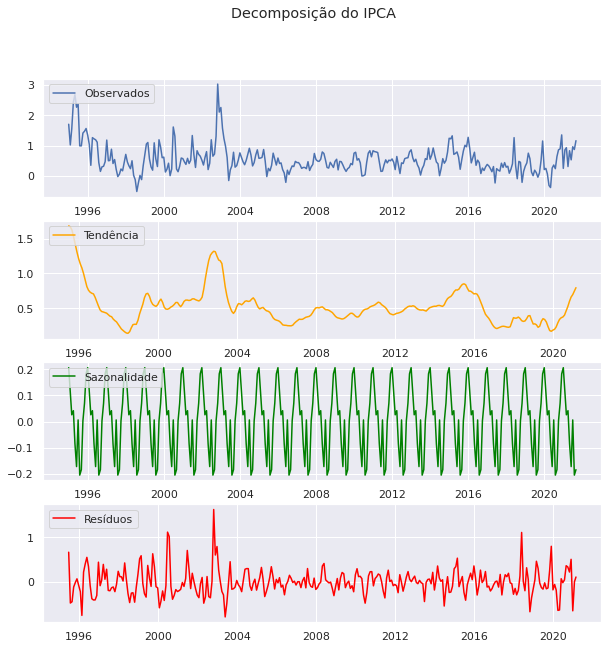

In [ ]:
# Definindo o tamanho da figura
fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize = (10,10))

# Gráfico com valores observados
ax[0].plot(decomposicao.observed, label='Observados')
ax[0].legend(loc='upper left')

# Gráfico com a tendência
ax[1].plot(decomposicao.trend, color = 'orange', label='Tendência')
ax[1].legend(loc='upper left')

# Gráfico com a Sazonalidade
ax[2].plot(decomposicao.seasonal, color = 'green', label='Sazonalidade')
ax[2].legend(loc='upper left')

# Gráfico com os resíduos
ax[3].plot(decomposicao.resid, color = 'red', label='Resíduos')
ax[3].legend(loc='upper left')

# Alterando o título
fig.suptitle('Decomposição do IPCA');

# Exibindo o gráfico
plt.show()

- Apresenta sazonalidade
- Não há uma tendência clara para toda série

## Teste Dickey Fuller na série

O Teste Dickey Fuller é um teste de raiz unitária que identifica estatisticamente se a série é estacionária

- **Hipótese nula (Ho):** a série *não é estacionária*
- **Hipótese Alternativa (Ha):** a série *é estacionária*

In [ ]:
# Calculando as medidas do teste Dickey Fuller
df = statsmodels.tsa.stattools.adfuller(ipca_treino)

print('Estatítica do teste: {:.4f}'.format(df[0]))
print('p-valor do teste: {:.8f}'.format(df[1]))
print('Valores Críticos:')
for chave, valor in df[4].items():
   print('{}: {:.4f}'.format(chave, valor))

Estatítica do teste: -4.7905
p-valor do teste: 0.00005671
Valores Críticos:
1%: -3.4518
5%: -2.8710
10%: -2.5718


A estísica do teste é menor que os valores críticos,  e  o p-valor é proximo de zero há evidências para rejeitar a hipótese nula, ou sejá a série é estacionária

## Teste Dickey Fuller na série diferenciada

Caso a série não sejá estacionária um método para resolver isso é diferenciar a série

In [ ]:
# Encontrando a diferença de primeira ordem
ipca_treino_diff = ipca_treino.diff()

# Retirando o NA gerado pela falta de valores antes da primeira observação
ipca_treino_diff.dropna(inplace = True)

In [ ]:
df = statsmodels.tsa.stattools.adfuller(ipca_treino_diff)

print('Estatítica do teste: {:.4f}'.format(df[0]))
print('p-valor do teste: {:.8f}'.format(df[1]))
print('Valores Críticos:')
for chave, valor in df[4].items():
   print('{}: {:.4f}'.format(chave, valor))

Estatítica do teste: -6.8832
p-valor do teste: 0.00000000
Valores Críticos:
1%: -3.4518
5%: -2.8710
10%: -2.5718


Como esperado a série diferenciada também é estácionária

## teste de auto correlação na série

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


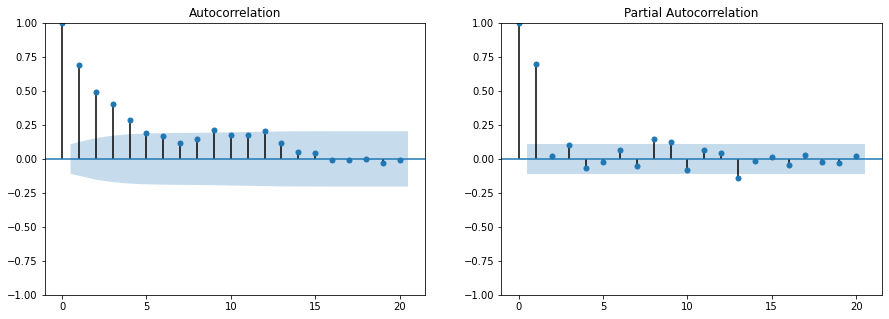

In [ ]:
# Definindo o tamanho da figura e disposições dos subplots
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

 # Fazendo o gráfico de autocorrelação e autocorrelação  parcial
plot_acf(ipca_treino, lags=20, ax=ax[0])
plot_pacf(ipca_treino, lags=20, ax=ax[1])

# Exibindo o gráfico
plt.show()

A série apresenta processos AR e MA

## teste de auto correlação na série série diferenciada

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


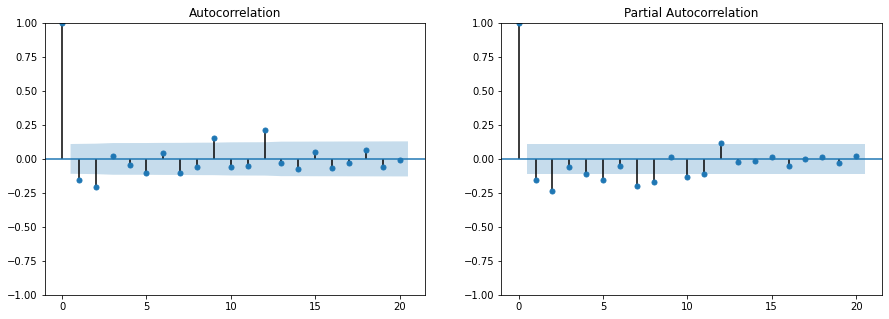

In [ ]:
# Definindo o tamanho da figura e disposições dos subplots
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

 # Fazendo o gráfico de autocorrelação e autocorrelação  parcial
plot_acf(ipca_treino_diff, lags=20, ax=ax[0])
plot_pacf(ipca_treino_diff, lags=20, ax=ax[1])

# Exibindo o gráfico
plt.show()

A série diferenciada apresenta processos AR e MA

# Auto Arima

## SARIMA Modelo autoregressivo sazonal de média móvel intergrado

O modelo ARIMA consegue lidar com tendência processos AR e MA, mas não consegue lidar com sazonalidade.

Para o modelo ARIMA temos que identificar os p,d,q

- p: Ordem do AR
- d: Ordem das diferenças
- q: Ordem do MA

Para o SARIMA, além dos elementos do ARIMA há os elementos sazonais.

- P: Ordem do AR sazonal
- D: Ordem das diferenças sazonais
- Q: Ordem do MA sazonal
- s: periódo do ciclo sazonal

## CRITÉRIO DE AIC

O pacote Auto arima, identifica os melhores elementos para cada componente.

O critério utilizado é o de AIC. O melhor modelo será o que tiver o menor AIC

O pacote Auto arima, identifica os melhores elementos para cada componente.

O critério utilizado é o de AIC

In [ ]:
### AUTOARIMA
modelo_autoarima = auto_arima(
    ipca_treino,
    trace = True,
    stepwise = False,
    seasonal=True,
    start_p=1,
    start_d=0,
    start_q=1,
    start_P=1,
    start_D=0,
    start_Q=1,
    max_p=4,
    max_d=1,
    max_q=4,
    max_P=4,
    max_D=1,
    max_Q=4,
    m=12)

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=252.360, Time=0.08 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=240.396, Time=0.20 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=239.375, Time=0.60 sec
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=238.999, Time=1.26 sec
 ARIMA(0,1,0)(0,0,4)[12] intercept   : AIC=240.746, Time=2.65 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=237.622, Time=0.25 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=232.772, Time=0.50 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=233.860, Time=1.36 sec
 ARIMA(0,1,0)(1,0,3)[12] intercept   : AIC=235.840, Time=4.51 sec
 ARIMA(0,1,0)(1,0,4)[12] intercept   : AIC=237.787, Time=8.17 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=237.007, Time=0.55 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=233.892, Time=1.60 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.12 sec
 ARIMA(0,1,0)(2,0,3)[12] intercept   : AIC=inf, Time=7.15 sec
 ARIMA(0,1,0)(3,0,0)[12] intercept   : AIC=237.182, Time=2.19 sec
 ARIMA(0,1,0)(3,0,

## Analisando resíduos do modelo escolhido pelo auto arima

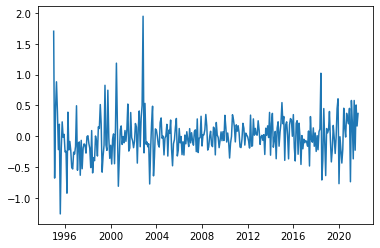

In [ ]:
# Ajustando o modelo selecionado aos dados
resultado_autoarima = modelo_autoarima.fit(ipca_treino)

# Pegando resíduos do modelo ajustado
residuos_modelo_autoarima = resultado_autoarima.resid

# Visualizando os resíduos
plt.plot(residuos_modelo_autoarima())

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


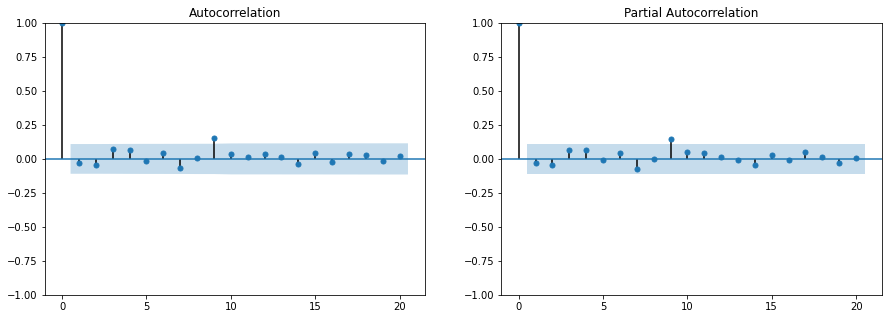

In [ ]:
# Definindo o tamanho da figura e disposições dos subplots
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

 # Fazendo o gráfico de autocorrelação e autocorrelação  parcial
plot_acf(residuos_modelo_autoarima(), lags=20, ax=ax[0])
plot_pacf(residuos_modelo_autoarima(), lags=20, ax=ax[1])

# Exibindo o gráfico
plt.show()

Não apresenta processos MA e AR

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


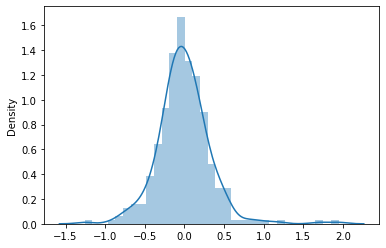

In [ ]:
# Visualizando a distribuição dos resíduos
sns.distplot(residuos_modelo_autoarima());

O gráfico sugere uma normalidade nos resíduos

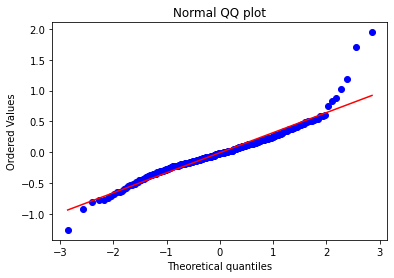

In [ ]:
# Verificando a normalidade dos resíduos através do QQ plot
stats.probplot(residuos_modelo_autoarima(), dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

# Avaliação do modelo

In [ ]:
# Verificando o valor do Critério de Informação de Akaike - AIC
resultado_autoarima.aic()

192.36020655101822

In [ ]:
ipca_modelo = resultado_autoarima.predict_in_sample()
ipca_modelo

Date
1995-01-01   -0.001704
1995-02-01    1.698296
1995-03-01    1.117805
1995-04-01    1.547854
1995-05-01    2.268914
                ...   
2021-05-01    0.250643
2021-06-01    0.756322
2021-07-01    0.453186
2021-08-01    0.704115
2021-09-01    0.791184
Freq: MS, Name: predicted_mean, Length: 321, dtype: float64

In [ ]:
previsao_autoarima = resultado_autoarima.predict(n_periods=12)
previsao_autoarima

2021-10-01    1.012721
2021-11-01    0.846143
2021-12-01    0.930119
2022-01-01    0.589597
2022-02-01    0.629031
2022-03-01    0.574273
2022-04-01    0.384164
2022-05-01    0.416386
2022-06-01    0.423564
2022-07-01    0.469874
2022-08-01    0.396642
2022-09-01    0.506730
Freq: MS, dtype: float64

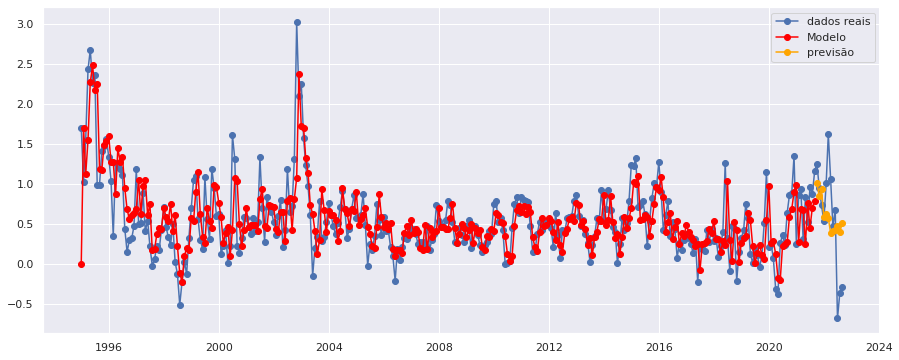

In [ ]:
# Plotando a série com dados reais e ajustados pelo modelo
fig, ax = plt.subplots(figsize = (15,6))
plt.plot(ipca, label='dados reais', marker = 'o')
plt.plot(ipca_modelo,color='red', label='Modelo', marker = 'o')
plt.plot(previsao_autoarima,color='orange', label='previsão', marker = 'o')
plt.legend(loc='best')
plt.show()

In [ ]:
corr = ipca_modelo.corr(ipca_treino)

In [ ]:
print('Correlação entre os dados de treino e a os estimados pelo modelo = {}'.format(corr))

Correlação entre os dados de treino e a os estimados pelo modelo = 0.7035184777147111


## Previsão e avaliação de 3, 6, 9 e 12 meses

- Será feita previsão para 3, 6, 9 e 12 meses na base de teste.
- As metrícas utilizados para avaliar o modelo com os dados reais são MAE e MAPE

- MAE (Mean Absoluto Error) erro médio absoluto: Mede a média da diferença entre o valor real com o predito
- MAPE(Mean Absolute Percentual Error) erro percentual absoluto médio: Mede a porcentagem dos erros em relação aos valores reais

In [ ]:
# Carregando bibliotecas necessárias
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [ ]:
previsao_autoarima_3 = resultado_autoarima.predict(n_periods=3)
previsao_autoarima_6 = resultado_autoarima.predict(n_periods=6)
previsao_autoarima_9 = resultado_autoarima.predict(n_periods=9)
previsao_autoarima_12 = resultado_autoarima.predict(n_periods=12)
previsao_autoarima_3

2021-10-01    1.012721
2021-11-01    0.846143
2021-12-01    0.930119
Freq: MS, dtype: float64

In [ ]:

print('Erro médio absoluto da previsão de 3 meses: MAE = {}'.format(mae_3))
print('Erro médio absoluto da previsão de 6 meses: MAE = {}'.format(mae_6))
print('Erro médio absoluto da previsão de 9 meses: MAE = {}'.format(mae_9))
print('Erro médio absoluto da previsão de 12 meses: MAE = {}'.format(mae_12))


print('\nErro Percentual Absoluto Médio da previsão de 3 meses : MAPE = {}'.format(mape_3))
print('Erro Percentual Absoluto Médio da previsão de 6 meses : MAPE = {}'.format(mape_6))
print('Erro Percentual Absoluto Médio da previsão de 9 meses : MAPE = {}'.format(mape_9))
print('Erro Percentual Absoluto Médio da previsão de 12 meses : MAPE = {}'.format(mape_12))

Erro médio absoluto da previsão de 3 meses: MAE = 0.18041826483616533
Erro médio absoluto da previsão de 6 meses: MAE = 0.3362579914608885
Erro médio absoluto da previsão de 9 meses: MAE = 0.33260377165498517
Erro médio absoluto da previsão de 12 meses: MAE = 0.4747233080412694

Erro Percentual Absoluto Médio da previsão de 3 meses : MAPE = 0.19109393949278639
Erro Percentual Absoluto Médio da previsão de 6 meses : MAPE = 0.28130598645867394
Erro Percentual Absoluto Médio da previsão de 9 meses : MAPE = 0.3119226682287915
Erro Percentual Absoluto Médio da previsão de 12 meses : MAPE = 0.7789518558781001


- O MAE de 3 meses é 0.18, de 6 meses e 9 meses é parecido ficando na casa dos 0,33, para 12 meses o MAE fica em 0,47

- O MAPE de 3 meses é 19%, de 6 meses 28% e de 9 meses 31%, para 12 meses ficou em 77%

- As previsões de 3 a 9 meses obtiveram relativamente bons acertos
- As previsões de 12 meses, com o intervalo maior, não foram tão acertadas

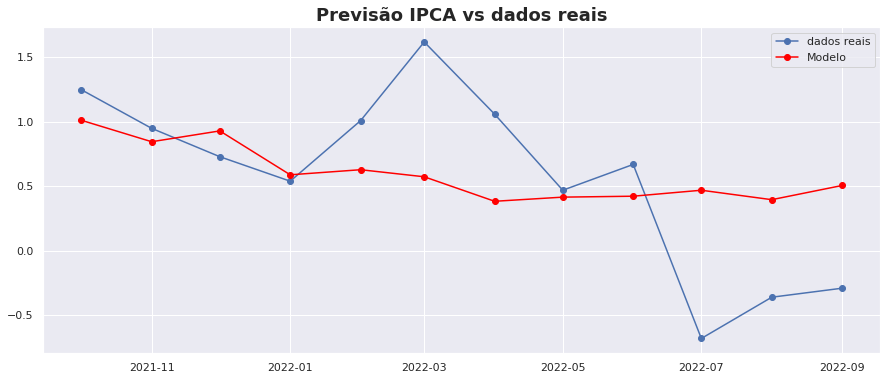

In [ ]:
# Plotando a série com dados reais e ajustados pelo modelo
fig, ax = plt.subplots(figsize = (15,6))
plt.plot(ipca_teste, label='dados reais', marker = 'o')
plt.plot(resultado_autoarima.predict(n_periods=12),color='red', label='Modelo', marker = 'o')
plt.title('Previsão IPCA vs dados reais', fontsize=18, fontweight='bold')
plt.legend(loc='best')
plt.show()

# Ajustando modelo auto arima na base toda para previsão para os próximos 12 meses

In [ ]:
## AUTOARIMA
modelo_final = auto_arima(
    ipca,
   trace = True,
    stepwise = False,
    seasonal=True,
    start_p=1,
    start_d=0,
    start_q=1,
    start_P=1,
    start_D=0,
    start_Q=1,
    max_p=4,
    max_d=1,
    max_q=4,
    max_P=4,
    max_D=1,
    max_Q=4,
    m=12)

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=276.050, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=265.960, Time=0.22 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=265.741, Time=0.71 sec
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=265.602, Time=1.73 sec
 ARIMA(0,1,0)(0,0,4)[12] intercept   : AIC=265.930, Time=2.80 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=263.868, Time=0.25 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=258.639, Time=0.51 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=260.187, Time=2.26 sec
 ARIMA(0,1,0)(1,0,3)[12] intercept   : AIC=261.921, Time=5.71 sec
 ARIMA(0,1,0)(1,0,4)[12] intercept   : AIC=263.740, Time=8.08 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=263.727, Time=0.77 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=260.229, Time=2.59 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.40 sec
 ARIMA(0,1,0)(2,0,3)[12] intercept   : AIC=264.047, Time=3.39 sec
 ARIMA(0,1,0)(3,0,0)[12] intercept   : AIC=263.279, Time=1.65 sec
 ARIMA(0,1,0)(

In [ ]:
# Ajustando o modelo selecionado aos dados
resultado_autoarima_final = modelo_final.fit(ipca)


In [ ]:
modelo_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  333
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -102.290
Date:                              Thu, 27 Oct 2022   AIC                            218.580
Time:                                      12:32:46   BIC                            245.216
Sample:                                  01-01-1995   HQIC                           229.202
                                       - 09-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -7.177e-05      0.000     -0.685      0.493      -0.000       0.000
ar.L1          0.6885      0.058     11.926      0.000       0.575       0.802
ma.L1         -0.9435      0.076    -12.350      0.000      -1.093      -0.794
ma.L2         -0.0405      0.072     -0.565      0.572      -0.181       0.100
ar.S.L12       0.8863      0.086     10.365      0.000       0.719       1.054
ma.S.L12      -0.7519      0.119     -6.331      0.000      -0.985      -0.519
sigma2         0.1071      0.005     20.354      0.000       0.097       0.117
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               340.96
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.49
Prob(H) (two-sided):                  0.05   Kurtosis:                         7.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

O modelo ajustado na base toda para realizar a previsão para os proximos 12 meses é um SARIMA (1, 1, 2), (1, 0, 1) 12

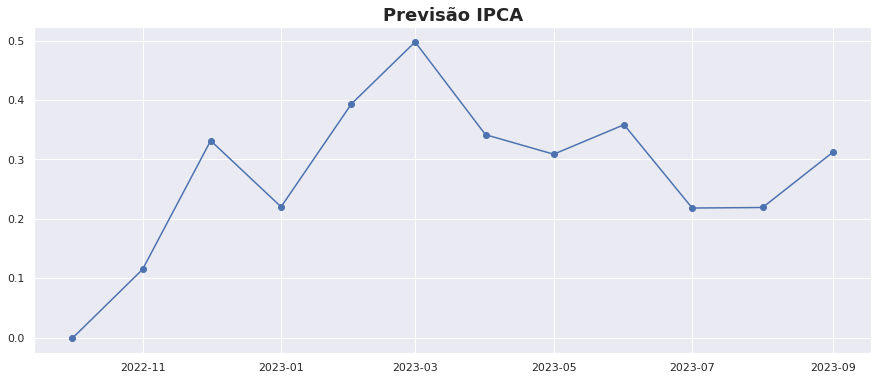

In [ ]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize = (15,6))
plt.title('Previsão IPCA', fontsize=18, fontweight='bold')
plt.plot(modelo_final.predict(n_periods=12), marker = 'o')
plt.show()

In [ ]:
modelo_final.predict(n_periods=12)

2022-10-01   -0.001351
2022-11-01    0.114886
2022-12-01    0.331731
2023-01-01    0.220284
2023-02-01    0.393723
2023-03-01    0.497874
2023-04-01    0.341767
2023-05-01    0.308888
2023-06-01    0.358523
2023-07-01    0.218270
2023-08-01    0.219177
2023-09-01    0.312456
Freq: MS, dtype: float64

Alguns links utilizados

- https://medium.com/data-hackers/prevendo-n%C3%BAmeros-entendendo-m%C3%A9tricas-de-regress%C3%A3o-35545e011e70

- https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/

- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

-